In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
# Load the dataset
# df = pd.read_csv('sufffle_image.csv')
df = pd.read_csv('Lungs X Ray.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [4]:
class_counts = df['category'].value_counts()
class_counts

category
COVID-19    140
Normal       28
Name: count, dtype: int64

In [5]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the 'Normal' class to match the count of the majority class ('COVID-19')
oversample = RandomOverSampler(sampling_strategy={'Normal': class_counts['COVID-19']})
X_resampled, y_resampled = oversample.fit_resample(df.drop(columns=['category']), df['category'])

# Combine the resampled data into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns.drop('category'))
df_resampled['category'] = y_resampled

# Check the class distribution after oversampling
print(df_resampled['category'].value_counts())

category
COVID-19    140
Normal      140
Name: count, dtype: int64


<Axes: xlabel='category'>

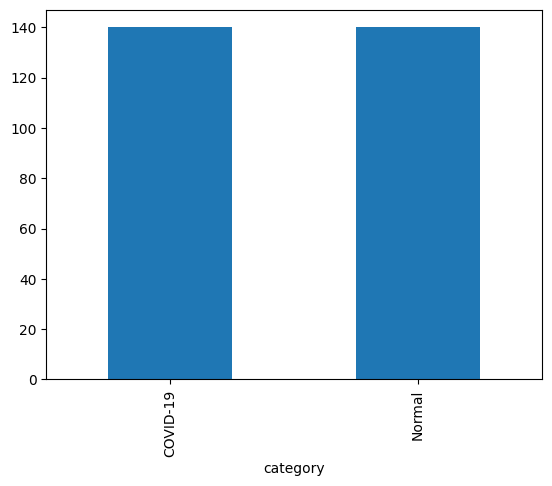

In [6]:
df_resampled['category'].value_counts().plot.bar()

In [10]:
df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)

In [11]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df_resampled, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 7

In [13]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     # zoom_range=0.2,
#     horizontal_flip=True,
    
#     brightness_range=[0.5, 1.5],
#     channel_shift_range=0.2,
#     vertical_flip=True,
#     preprocessing_function=lambda x: x + 0.01 * np.random.randn(*x.shape),
#     # random_rotation=30,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     zoom_range=[0.8, 1.2],
#     # Exclude unsupported parameter
# )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 224 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.


In [ ]:
# # Freeze layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

In [14]:
def sequential1(model,units):
   
    model.add(Conv2D(units,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(units,(3,3),padding = 'same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides= 2))
    return model

In [15]:
def sequential2(model,size):
    
    model.add(Dense(size,activation='relu'))
    model.add(Dense(size,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    return model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

# Conv2d_2 (conv2d) (180, 180, 16) 448
model.add(Conv2D(16, (3, 3), input_shape=(180, 180, 3), padding='same', activation='relu'))
# Conv2d_3 (conv2d) (180, 180, 16) 2320
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# Max_pooling2d_1 (90, 90, 16) 0
model.add(MaxPooling2D(pool_size=(2, 2), strides= 2))
sequential1(model,32)
sequential1(model,64)
sequential1(model,128)
# Dropout (dropout) (11, 11, 128) 0
model.add(Dropout(0.5))

sequential1(model,256)

# Dropout_1 (dropout) (5, 5, 256) 0
model.add(Dropout(0.5))

# Flatten (flatten) (6400) 0
model.add(Flatten())

# Sequential_4 (sequential) (512) 3279360
sequential2(model,512)
sequential2(model,128)
sequential2(model,64)


# Dense_7 (dense) (512) 33280
model.add(Dense(512, activation='relu'))
# Dense_8 (dense) (3) 1539
# model.add(Dense(3, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                          

In [17]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

In [18]:
custom_loss = CustomLoss()

In [19]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=0.001), loss=custom_loss, metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                          

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop, learning_rate_reduction]
# callbacks = [learning_rate_reduction]

In [21]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [22]:
# Fit the model
epochs = 100

# history = model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate // batch_size,
#     steps_per_epoch=total_train // batch_size,
#     callbacks=callbacks
# )
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

Epoch 1/100
32/32 [==============================] - 13s 152ms/step - loss: 0.7328 - accuracy: 0.5134 - val_loss: 0.7020 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 4s 135ms/step - loss: 0.7166 - accuracy: 0.5848 - val_loss: 0.8316 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 4s 135ms/step - loss: 0.6445 - accuracy: 0.6830 - val_loss: 0.8926 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 4s 135ms/step - loss: 0.5978 - accuracy: 0.7143 - val_loss: 1.2340 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 4s 133ms/step - loss: 0.5362 - accuracy: 0.7634 - val_loss: 1.6741 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 4s 134ms/step - loss: 0.4271 - accuracy: 0.8125 - val_loss: 1.6497 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 6s 181ms/s

In [25]:
model.save('lung_ds.h5')


In [26]:
actual_epochs = len(history.history['loss'])

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

In [ ]:
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

In [ ]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
predict

In [ ]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [ ]:
test_df.head()

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [ ]:
test_df.head()

In [ ]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [ ]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
# print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

In [ ]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
print(classification_report(actual, pred))

In [ ]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Load Model to Visualize

In [ ]:
# from keras.models import load_model
# model.load_weights('cnn3281135.h5')

In [ ]:
# from vis.visualization import visualize_saliency
# from vis.utils import utils
# import matplotlib.pyplot as plt
# import scipy.ndimage as ndimage
# import numpy as np
# import cv2
# from keras import activations
# from skimage.transform import resize

In [ ]:
# pip install scipy==1.1.0